Package loading

In [2]:
import torch
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

# 이걸 해줘야 matplotlib 시행 시 에러가 안 남
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

pytorch version: 2.1.2
pytorch version: 2.1.2
GPU 사용 가능 여부: True


Hyperparameters

In [3]:
batch_size = 128
num_epochs = 50
learning_rate = 0.001

Data Loader

In [4]:
# For Kaggle notebook
data_dir = '/kaggle/input/kermany2018/OCT2017 /'

class OCTDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode,'*', '*')))
        self.transform = transform
    
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform is not None:
            img = self.transform(img)
        img = img.squeeze()
        img = torch.stack((img, img, img,), dim=0)  # densenet이 3 channel이라 concat시키기
        name = os.path.basename(data_path)
        if name.startswith('NORMAL'):
            label = 0
        elif name.startswith('CNV'):
            label = 1
        elif name.startswith('DME'):
            label = 2
        elif name.startswith('DRUSEN'):
            label = 3
        return img, label
    
    def __len__(self):
        length = len(self.all_data)
        return length

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ])
}

In [5]:
train_data = OCTDataset(data_dir=data_dir, mode='train', transform=data_transforms['train'])
val_data = OCTDataset(data_dir=data_dir, mode='val', transform=data_transforms['val'])
test_data = OCTDataset(data_dir=data_dir, mode='test', transform=data_transforms['val'])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=2)  # num_worker로 Multi Process Data Loading 구현
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2) # Kaggle CPU = 2 core
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

train_mean = 0.1881
train_std = 0.1850

Model: MobileNet v2 Transfer Learning

In [6]:
class TransferMobileNetV2(nn.Module):
    def __init__ (self, num_classes):
        super(TransferMobileNetV2, self).__init__()
        self.mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)
        num_feature = torchvision.models.mobilenet_v2(pretrained=True).classifier[1].in_features
        self.mobilenet_v2.classifier[1] = nn.Linear(num_feature, num_classes)
        
    def forward(self,x):
        return self.mobilenet_v2(x)

mobilenetv2_transfer = TransferMobileNetV2(num_classes=4).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s]


In [7]:
# Inversed residual 13부터 -> 109 미만은 false, 이후는 True
count = 0
for param in mobilenetv2_transfer.mobilenet_v2.parameters():
    count += 1
    if count >= 109:
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in mobilenetv2_transfer.named_parameters():
    print(name, param.requires_grad)

mobilenet_v2.features.0.0.weight False
mobilenet_v2.features.0.1.weight False
mobilenet_v2.features.0.1.bias False
mobilenet_v2.features.1.conv.0.0.weight False
mobilenet_v2.features.1.conv.0.1.weight False
mobilenet_v2.features.1.conv.0.1.bias False
mobilenet_v2.features.1.conv.1.weight False
mobilenet_v2.features.1.conv.2.weight False
mobilenet_v2.features.1.conv.2.bias False
mobilenet_v2.features.2.conv.0.0.weight False
mobilenet_v2.features.2.conv.0.1.weight False
mobilenet_v2.features.2.conv.0.1.bias False
mobilenet_v2.features.2.conv.1.0.weight False
mobilenet_v2.features.2.conv.1.1.weight False
mobilenet_v2.features.2.conv.1.1.bias False
mobilenet_v2.features.2.conv.2.weight False
mobilenet_v2.features.2.conv.3.weight False
mobilenet_v2.features.2.conv.3.bias False
mobilenet_v2.features.3.conv.0.0.weight False
mobilenet_v2.features.3.conv.0.1.weight False
mobilenet_v2.features.3.conv.0.1.bias False
mobilenet_v2.features.3.conv.1.0.weight False
mobilenet_v2.features.3.conv.1.1.we

In [8]:
# Inversed residual 13 이후의 Conv layer를 다시 initialization
for name, param in mobilenetv2_transfer.mobilenet_v2.features.named_parameters():
    name_list = name.split('.')
    if (int(name_list[0]) >= 13) and (name_list[1] == 'conv') and (name_list[-2]=='0') and (name_list[-1]=='weight'):
        # 해당 Conv layer parameter initialization
        print(f'{name}의 convolution weight')
        nn.init.xavier_uniform_(param)
        print(name+'의 conv filter initialization setting 완료')
        print()

13.conv.0.0.weight의 convolution weight
13.conv.0.0.weight의 conv filter initialization setting 완료

13.conv.1.0.weight의 convolution weight
13.conv.1.0.weight의 conv filter initialization setting 완료

14.conv.0.0.weight의 convolution weight
14.conv.0.0.weight의 conv filter initialization setting 완료

14.conv.1.0.weight의 convolution weight
14.conv.1.0.weight의 conv filter initialization setting 완료

15.conv.0.0.weight의 convolution weight
15.conv.0.0.weight의 conv filter initialization setting 완료

15.conv.1.0.weight의 convolution weight
15.conv.1.0.weight의 conv filter initialization setting 완료

16.conv.0.0.weight의 convolution weight
16.conv.0.0.weight의 conv filter initialization setting 완료

16.conv.1.0.weight의 convolution weight
16.conv.1.0.weight의 conv filter initialization setting 완료

17.conv.0.0.weight의 convolution weight
17.conv.0.0.weight의 conv filter initialization setting 완료

17.conv.1.0.weight의 convolution weight
17.conv.1.0.weight의 conv filter initialization setting 완료



In [9]:
# 각 Inversed residual의 batch norm은 residual block 전 마지막 batch norm이므로 gamma zero로 초기화
# Beta도 zero로 초기화
for name, param in mobilenetv2_transfer.mobilenet_v2.features.named_parameters():
    name_list = name.split('.')
    if (int(name_list[0]) >= 13) and (name_list[1] == 'conv') and (name_list[-2]=='1') and (name_list[-1]=='weight'):
        # 해당 Batch normalization의 gamma zero
        print(f'{name}의 batch norm의 weight')
        nn.init.ones_(param)
        print(name+'의 gamma one setting 완료')
        print()
    elif (int(name_list[0]) >= 13) and (name_list[1] == 'conv') and (name_list[-2]=='1') and (name_list[-1]=='bias'):
        print(f'{name}의 batch norm의 bias')
        nn.init.zeros_(param)
        print(name+'의 beta zero setting 완료')
        print()

13.conv.0.1.weight의 batch norm의 weight
13.conv.0.1.weight의 gamma one setting 완료

13.conv.0.1.bias의 batch norm의 bias
13.conv.0.1.bias의 beta zero setting 완료

13.conv.1.1.weight의 batch norm의 weight
13.conv.1.1.weight의 gamma one setting 완료

13.conv.1.1.bias의 batch norm의 bias
13.conv.1.1.bias의 beta zero setting 완료

14.conv.0.1.weight의 batch norm의 weight
14.conv.0.1.weight의 gamma one setting 완료

14.conv.0.1.bias의 batch norm의 bias
14.conv.0.1.bias의 beta zero setting 완료

14.conv.1.1.weight의 batch norm의 weight
14.conv.1.1.weight의 gamma one setting 완료

14.conv.1.1.bias의 batch norm의 bias
14.conv.1.1.bias의 beta zero setting 완료

15.conv.0.1.weight의 batch norm의 weight
15.conv.0.1.weight의 gamma one setting 완료

15.conv.0.1.bias의 batch norm의 bias
15.conv.0.1.bias의 beta zero setting 완료

15.conv.1.1.weight의 batch norm의 weight
15.conv.1.1.weight의 gamma one setting 완료

15.conv.1.1.bias의 batch norm의 bias
15.conv.1.1.bias의 beta zero setting 완료

16.conv.0.1.weight의 batch norm의 weight
16.conv.0.1.weight의 gamma

Checkpoint, Train, val, test etc...

In [10]:
def save_model(model, epoch, optimizer, epoch_loss, val_accuracy, saved_dir):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }
    val_accuracy = round(val_accuracy,1)
    file_name = str(f"ckpoint_{epoch+1}_{val_accuracy}%.pt")
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point,output_path)

In [11]:
logs_base_dir = "./logs/logs_transfer"
os.makedirs(logs_base_dir, exist_ok=True)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(logs_base_dir)

2024-05-16 07:00:50.757700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 07:00:50.757795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 07:00:50.897970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
def train(num_epochs, model, data_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer):
    print('Start training..')
    torch.cuda.empty_cache()
    best_loss = 9999999
    best_epoch = 0
    count = 0
    for epoch in tqdm(range(num_epochs), desc='epoch'):
        # running_loss = 0.0
        for i, (imgs, labels) in tqdm(enumerate(data_loader), desc="in epoch"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()

            if (i+1) % 30 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))
            if (i+1) % 50 == 0:
                writer.add_scalar('Loss/Train', loss, i)
                writer.add_scalar('Accuracy/Train', accuracy, i)
            #if i % 30 == 29:
                #loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
                #running_loss = 0.0
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_accuracy = validation(epoch + 1, model, val_loader, criterion, device)
            # Saving validation loss and accuracy
            writer.add_scalar('Loss/Validation', avrg_loss, epoch+1)
            writer.add_scalar('Accuracy/Validation', val_accuracy, epoch+1)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, epoch, optimizer, avrg_loss, val_accuracy, saved_dir)
                count = 0
                best_epoch = epoch + 1
            else:
                count += 1
                print(f'Best epoch does not appear / Previous best epoch:{best_epoch}')
                print(f'A number of epochs remain until early stop: {10-count}')
                if count >= 10:
                    print('Best performance does not occur within 10 epochs. Early stopping!!')
                    scheduler.step()
                    writer.flush()
            ''' Only for local setting
            loss_tracker(loss_plt, torch.Tensor([avrg_loss]), torch.Tensor([epoch]))'''
        scheduler.step()
    writer.flush()

def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch) )
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs,labels)
            
            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        val_accuracy = correct / total * 100
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, val_accuracy, avrg_loss))
    model.train()
    return avrg_loss, val_accuracy

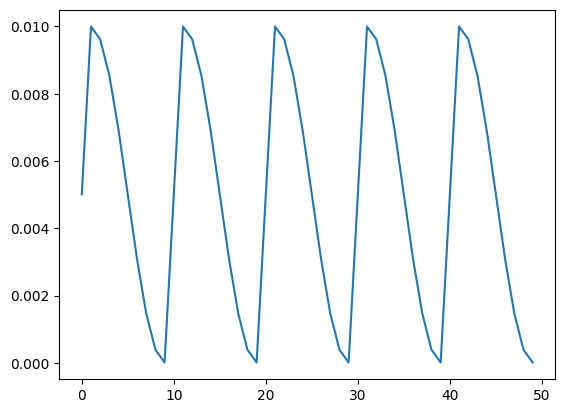

In [13]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, first_cycle_steps, cycle_mult = 1.0, max_lr = 0.1, min_lr = 0.001, warmup_steps = 0, gamma = 1.0, last_epoch = -1):
        # first_cycle_steps은 최초 주기, cycle_mult 다음 주기가 몇 배 늘어나는지
        # max_lr는 LR이 얼마까지 높아지는지, gamma는 주기 반복 시 max_lr에 곱해지는 값 (LR max를 줄이는 역할)
        # warmup_steps은 Warm up 시 필요한 epoch 수를 지정 (일반적으로 짧은 epoch 수를 지정)
        self.first_cycle_steps = first_cycle_steps
        self.cycle_mult = cycle_mult
        self.base_max_lr = max_lr                       # first max learning rate
        self.max_lr = max_lr                            # max learning rate in the current cycle
        self.min_lr = min_lr                            # min learning rate
        self.warmup_steps = warmup_steps                # warmup step size
        self.gamma = gamma                              # decrease rate of max learning rate by cycle
        
        self.cur_cycle_steps = first_cycle_steps        # first cycle step size
        self.cycle = 0                                  # cycle count
        self.step_in_cycle = last_epoch                 # step size of the current cycle

        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
        # parameter에 저장된 LR을 처음 LR로 저장
    
    def get_lr(self):
        if self.step_in_cycle == -1:                    # 첫 시작일 때
            return self.base_lrs                        # 그냥 base LR을 반영
        elif self.step_in_cycle < self.warmup_steps:    # 현재 epoch이 warmup_steps (warm up 단계) 안일 때
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
            # 첫 시작 LR~최대 LR까지 선형으로 증가시키기
        else:                                           # warm up 단계 이후일 때
            return [base_lr + (self.max_lr - base_lr) * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]
            #cosine annealing을 적용

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

import torch
import matplotlib.pyplot as plt

model = torch.nn.Linear(2, 1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, first_cycle_steps=10, cycle_mult = 1.0, max_lr = 0.01, min_lr = 0.00001, warmup_steps = 2, gamma = 1.0, last_epoch = -1)


lrs = []

for i in range(num_epochs):
    lr_scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(lrs)

In [14]:
# Case 2: Cosine Annealing with warm up start 사용
torch.manual_seed(7777)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(mobilenetv2_transfer.parameters(), lr=0.00001)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, first_cycle_steps=10, cycle_mult = 1.0, max_lr = 0.01, min_lr = 0.00001, warmup_steps = 2, gamma = 1.0, last_epoch = -1)

val_every = 1
saved_dir = './saved'

In [15]:
train(num_epochs, mobilenetv2_transfer, train_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer)

Start training..


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

in epoch: 0it [00:00, ?it/s]

Epoch [1/50], Step [30/653], Loss: 1.2414, Accuracy: 49.22%
Epoch [1/50], Step [60/653], Loss: 1.1927, Accuracy: 57.81%
Epoch [1/50], Step [90/653], Loss: 1.0104, Accuracy: 67.19%
Epoch [1/50], Step [120/653], Loss: 1.0120, Accuracy: 60.94%
Epoch [1/50], Step [150/653], Loss: 0.8061, Accuracy: 69.53%
Epoch [1/50], Step [180/653], Loss: 0.7634, Accuracy: 70.31%
Epoch [1/50], Step [210/653], Loss: 0.6970, Accuracy: 74.22%
Epoch [1/50], Step [240/653], Loss: 0.6437, Accuracy: 76.56%
Epoch [1/50], Step [270/653], Loss: 0.5742, Accuracy: 77.34%
Epoch [1/50], Step [300/653], Loss: 0.5864, Accuracy: 77.34%
Epoch [1/50], Step [330/653], Loss: 0.6071, Accuracy: 74.22%
Epoch [1/50], Step [360/653], Loss: 0.6345, Accuracy: 78.91%
Epoch [1/50], Step [390/653], Loss: 0.5940, Accuracy: 78.12%
Epoch [1/50], Step [420/653], Loss: 0.4332, Accuracy: 84.38%
Epoch [1/50], Step [450/653], Loss: 0.6538, Accuracy: 75.78%
Epoch [1/50], Step [480/653], Loss: 0.4085, Accuracy: 85.16%
Epoch [1/50], Step [510/653

in epoch: 0it [00:00, ?it/s]

Epoch [2/50], Step [30/653], Loss: 0.6653, Accuracy: 82.81%
Epoch [2/50], Step [60/653], Loss: 0.2846, Accuracy: 89.84%
Epoch [2/50], Step [90/653], Loss: 0.3266, Accuracy: 85.94%
Epoch [2/50], Step [120/653], Loss: 0.1980, Accuracy: 92.97%
Epoch [2/50], Step [150/653], Loss: 0.2329, Accuracy: 92.97%
Epoch [2/50], Step [180/653], Loss: 0.2085, Accuracy: 92.19%
Epoch [2/50], Step [210/653], Loss: 0.1806, Accuracy: 93.75%
Epoch [2/50], Step [240/653], Loss: 0.2135, Accuracy: 94.53%
Epoch [2/50], Step [270/653], Loss: 0.1736, Accuracy: 93.75%
Epoch [2/50], Step [300/653], Loss: 0.1880, Accuracy: 95.31%
Epoch [2/50], Step [330/653], Loss: 0.1719, Accuracy: 92.19%
Epoch [2/50], Step [360/653], Loss: 0.2517, Accuracy: 92.19%
Epoch [2/50], Step [390/653], Loss: 0.1852, Accuracy: 92.19%
Epoch [2/50], Step [420/653], Loss: 0.1990, Accuracy: 96.09%
Epoch [2/50], Step [450/653], Loss: 0.2492, Accuracy: 92.97%
Epoch [2/50], Step [480/653], Loss: 0.3854, Accuracy: 88.28%
Epoch [2/50], Step [510/653

in epoch: 0it [00:00, ?it/s]

Epoch [3/50], Step [30/653], Loss: 0.1491, Accuracy: 94.53%
Epoch [3/50], Step [60/653], Loss: 0.1877, Accuracy: 91.41%
Epoch [3/50], Step [90/653], Loss: 0.2768, Accuracy: 91.41%
Epoch [3/50], Step [120/653], Loss: 0.2194, Accuracy: 91.41%
Epoch [3/50], Step [150/653], Loss: 0.4388, Accuracy: 87.50%
Epoch [3/50], Step [180/653], Loss: 0.2673, Accuracy: 93.75%
Epoch [3/50], Step [210/653], Loss: 0.1688, Accuracy: 93.75%
Epoch [3/50], Step [240/653], Loss: 0.1239, Accuracy: 96.09%
Epoch [3/50], Step [270/653], Loss: 0.1390, Accuracy: 94.53%
Epoch [3/50], Step [300/653], Loss: 0.1701, Accuracy: 92.19%
Epoch [3/50], Step [330/653], Loss: 0.1231, Accuracy: 96.09%
Epoch [3/50], Step [360/653], Loss: 0.2709, Accuracy: 88.28%
Epoch [3/50], Step [390/653], Loss: 0.2717, Accuracy: 92.97%
Epoch [3/50], Step [420/653], Loss: 0.2470, Accuracy: 92.97%
Epoch [3/50], Step [450/653], Loss: 0.2276, Accuracy: 92.97%
Epoch [3/50], Step [480/653], Loss: 0.1683, Accuracy: 93.75%
Epoch [3/50], Step [510/653

in epoch: 0it [00:00, ?it/s]

Epoch [4/50], Step [30/653], Loss: 0.1555, Accuracy: 95.31%
Epoch [4/50], Step [60/653], Loss: 0.1101, Accuracy: 97.66%
Epoch [4/50], Step [90/653], Loss: 0.1607, Accuracy: 93.75%
Epoch [4/50], Step [120/653], Loss: 0.1547, Accuracy: 94.53%
Epoch [4/50], Step [150/653], Loss: 0.2220, Accuracy: 92.97%
Epoch [4/50], Step [180/653], Loss: 0.1310, Accuracy: 93.75%
Epoch [4/50], Step [210/653], Loss: 0.0941, Accuracy: 96.09%
Epoch [4/50], Step [240/653], Loss: 0.1376, Accuracy: 95.31%
Epoch [4/50], Step [270/653], Loss: 0.2695, Accuracy: 92.19%
Epoch [4/50], Step [300/653], Loss: 0.0824, Accuracy: 98.44%
Epoch [4/50], Step [330/653], Loss: 0.1648, Accuracy: 96.88%
Epoch [4/50], Step [360/653], Loss: 0.0645, Accuracy: 99.22%
Epoch [4/50], Step [390/653], Loss: 0.1034, Accuracy: 96.09%
Epoch [4/50], Step [420/653], Loss: 0.2200, Accuracy: 91.41%
Epoch [4/50], Step [450/653], Loss: 0.1524, Accuracy: 93.75%
Epoch [4/50], Step [480/653], Loss: 0.1552, Accuracy: 94.53%
Epoch [4/50], Step [510/653

in epoch: 0it [00:00, ?it/s]

Epoch [5/50], Step [30/653], Loss: 0.1193, Accuracy: 96.88%
Epoch [5/50], Step [60/653], Loss: 0.1399, Accuracy: 95.31%
Epoch [5/50], Step [90/653], Loss: 0.1785, Accuracy: 91.41%
Epoch [5/50], Step [120/653], Loss: 0.1441, Accuracy: 93.75%
Epoch [5/50], Step [150/653], Loss: 0.1619, Accuracy: 94.53%
Epoch [5/50], Step [180/653], Loss: 0.1301, Accuracy: 94.53%
Epoch [5/50], Step [210/653], Loss: 0.1671, Accuracy: 93.75%
Epoch [5/50], Step [240/653], Loss: 0.2321, Accuracy: 90.62%
Epoch [5/50], Step [270/653], Loss: 0.2694, Accuracy: 90.62%
Epoch [5/50], Step [300/653], Loss: 0.1786, Accuracy: 91.41%
Epoch [5/50], Step [330/653], Loss: 0.0931, Accuracy: 97.66%
Epoch [5/50], Step [360/653], Loss: 0.0756, Accuracy: 97.66%
Epoch [5/50], Step [390/653], Loss: 0.2649, Accuracy: 90.62%
Epoch [5/50], Step [420/653], Loss: 0.1734, Accuracy: 92.97%
Epoch [5/50], Step [450/653], Loss: 0.1234, Accuracy: 96.09%
Epoch [5/50], Step [480/653], Loss: 0.1860, Accuracy: 93.75%
Epoch [5/50], Step [510/653

in epoch: 0it [00:00, ?it/s]

Epoch [6/50], Step [30/653], Loss: 0.1654, Accuracy: 93.75%
Epoch [6/50], Step [60/653], Loss: 0.0718, Accuracy: 98.44%
Epoch [6/50], Step [90/653], Loss: 0.1013, Accuracy: 96.88%
Epoch [6/50], Step [120/653], Loss: 0.1035, Accuracy: 96.88%
Epoch [6/50], Step [150/653], Loss: 0.1072, Accuracy: 96.88%
Epoch [6/50], Step [180/653], Loss: 0.2422, Accuracy: 94.53%
Epoch [6/50], Step [210/653], Loss: 0.0969, Accuracy: 96.88%
Epoch [6/50], Step [240/653], Loss: 0.0775, Accuracy: 96.09%
Epoch [6/50], Step [270/653], Loss: 0.1651, Accuracy: 93.75%
Epoch [6/50], Step [300/653], Loss: 0.1632, Accuracy: 93.75%
Epoch [6/50], Step [330/653], Loss: 0.2181, Accuracy: 97.66%
Epoch [6/50], Step [360/653], Loss: 0.2371, Accuracy: 92.97%
Epoch [6/50], Step [390/653], Loss: 0.1334, Accuracy: 96.09%
Epoch [6/50], Step [420/653], Loss: 0.0890, Accuracy: 97.66%
Epoch [6/50], Step [450/653], Loss: 0.2007, Accuracy: 92.97%
Epoch [6/50], Step [480/653], Loss: 0.1109, Accuracy: 96.88%
Epoch [6/50], Step [510/653

in epoch: 0it [00:00, ?it/s]

Epoch [7/50], Step [30/653], Loss: 0.1642, Accuracy: 96.09%
Epoch [7/50], Step [60/653], Loss: 0.1569, Accuracy: 92.19%
Epoch [7/50], Step [90/653], Loss: 0.1968, Accuracy: 94.53%
Epoch [7/50], Step [120/653], Loss: 0.1445, Accuracy: 91.41%
Epoch [7/50], Step [150/653], Loss: 0.0882, Accuracy: 95.31%
Epoch [7/50], Step [180/653], Loss: 0.0775, Accuracy: 96.88%
Epoch [7/50], Step [210/653], Loss: 0.1281, Accuracy: 95.31%
Epoch [7/50], Step [240/653], Loss: 0.2633, Accuracy: 92.19%
Epoch [7/50], Step [270/653], Loss: 0.2294, Accuracy: 92.19%
Epoch [7/50], Step [300/653], Loss: 0.1186, Accuracy: 96.88%
Epoch [7/50], Step [330/653], Loss: 0.2989, Accuracy: 91.41%
Epoch [7/50], Step [360/653], Loss: 0.0644, Accuracy: 98.44%
Epoch [7/50], Step [390/653], Loss: 0.1667, Accuracy: 94.53%
Epoch [7/50], Step [420/653], Loss: 0.1638, Accuracy: 94.53%
Epoch [7/50], Step [450/653], Loss: 0.1528, Accuracy: 93.75%
Epoch [7/50], Step [480/653], Loss: 0.2094, Accuracy: 93.75%
Epoch [7/50], Step [510/653

in epoch: 0it [00:00, ?it/s]

Epoch [8/50], Step [30/653], Loss: 0.1461, Accuracy: 95.31%
Epoch [8/50], Step [60/653], Loss: 0.0551, Accuracy: 98.44%
Epoch [8/50], Step [90/653], Loss: 0.1094, Accuracy: 96.09%
Epoch [8/50], Step [120/653], Loss: 0.1202, Accuracy: 96.88%
Epoch [8/50], Step [150/653], Loss: 0.1148, Accuracy: 96.09%
Epoch [8/50], Step [180/653], Loss: 0.0736, Accuracy: 96.88%
Epoch [8/50], Step [210/653], Loss: 0.0851, Accuracy: 97.66%
Epoch [8/50], Step [240/653], Loss: 0.0525, Accuracy: 99.22%
Epoch [8/50], Step [270/653], Loss: 0.1035, Accuracy: 96.88%
Epoch [8/50], Step [300/653], Loss: 0.0895, Accuracy: 96.88%
Epoch [8/50], Step [330/653], Loss: 0.1209, Accuracy: 94.53%
Epoch [8/50], Step [360/653], Loss: 0.1233, Accuracy: 96.88%
Epoch [8/50], Step [390/653], Loss: 0.0986, Accuracy: 96.09%
Epoch [8/50], Step [420/653], Loss: 0.0968, Accuracy: 94.53%
Epoch [8/50], Step [450/653], Loss: 0.1837, Accuracy: 95.31%
Epoch [8/50], Step [480/653], Loss: 0.1391, Accuracy: 95.31%
Epoch [8/50], Step [510/653

in epoch: 0it [00:00, ?it/s]

Epoch [9/50], Step [30/653], Loss: 0.0815, Accuracy: 95.31%
Epoch [9/50], Step [60/653], Loss: 0.2252, Accuracy: 93.75%
Epoch [9/50], Step [90/653], Loss: 0.1110, Accuracy: 96.09%
Epoch [9/50], Step [120/653], Loss: 0.0852, Accuracy: 96.09%
Epoch [9/50], Step [150/653], Loss: 0.0917, Accuracy: 97.66%
Epoch [9/50], Step [180/653], Loss: 0.0854, Accuracy: 96.09%
Epoch [9/50], Step [210/653], Loss: 0.0308, Accuracy: 99.22%
Epoch [9/50], Step [240/653], Loss: 0.1473, Accuracy: 95.31%
Epoch [9/50], Step [270/653], Loss: 0.0500, Accuracy: 100.00%
Epoch [9/50], Step [300/653], Loss: 0.0826, Accuracy: 96.09%
Epoch [9/50], Step [330/653], Loss: 0.1500, Accuracy: 96.09%
Epoch [9/50], Step [360/653], Loss: 0.1386, Accuracy: 95.31%
Epoch [9/50], Step [390/653], Loss: 0.1008, Accuracy: 95.31%
Epoch [9/50], Step [420/653], Loss: 0.1078, Accuracy: 97.66%
Epoch [9/50], Step [450/653], Loss: 0.0960, Accuracy: 97.66%
Epoch [9/50], Step [480/653], Loss: 0.1694, Accuracy: 95.31%
Epoch [9/50], Step [510/65

in epoch: 0it [00:00, ?it/s]

Epoch [10/50], Step [30/653], Loss: 0.0750, Accuracy: 98.44%
Epoch [10/50], Step [60/653], Loss: 0.1192, Accuracy: 96.88%
Epoch [10/50], Step [90/653], Loss: 0.1326, Accuracy: 96.88%
Epoch [10/50], Step [120/653], Loss: 0.0997, Accuracy: 96.09%
Epoch [10/50], Step [150/653], Loss: 0.1967, Accuracy: 96.09%
Epoch [10/50], Step [180/653], Loss: 0.0781, Accuracy: 96.09%
Epoch [10/50], Step [210/653], Loss: 0.0736, Accuracy: 96.88%
Epoch [10/50], Step [240/653], Loss: 0.1380, Accuracy: 94.53%
Epoch [10/50], Step [270/653], Loss: 0.0570, Accuracy: 96.88%
Epoch [10/50], Step [300/653], Loss: 0.0424, Accuracy: 97.66%
Epoch [10/50], Step [330/653], Loss: 0.1721, Accuracy: 95.31%
Epoch [10/50], Step [360/653], Loss: 0.0863, Accuracy: 95.31%
Epoch [10/50], Step [390/653], Loss: 0.1074, Accuracy: 95.31%
Epoch [10/50], Step [420/653], Loss: 0.1095, Accuracy: 94.53%
Epoch [10/50], Step [450/653], Loss: 0.1208, Accuracy: 95.31%
Epoch [10/50], Step [480/653], Loss: 0.1812, Accuracy: 94.53%
Epoch [10/5

in epoch: 0it [00:00, ?it/s]

Epoch [11/50], Step [30/653], Loss: 0.0865, Accuracy: 94.53%
Epoch [11/50], Step [60/653], Loss: 0.0832, Accuracy: 96.88%
Epoch [11/50], Step [90/653], Loss: 0.0443, Accuracy: 98.44%
Epoch [11/50], Step [120/653], Loss: 0.0418, Accuracy: 98.44%
Epoch [11/50], Step [150/653], Loss: 0.1572, Accuracy: 94.53%
Epoch [11/50], Step [180/653], Loss: 0.0881, Accuracy: 96.88%
Epoch [11/50], Step [210/653], Loss: 0.0809, Accuracy: 98.44%
Epoch [11/50], Step [240/653], Loss: 0.1038, Accuracy: 96.09%
Epoch [11/50], Step [270/653], Loss: 0.0668, Accuracy: 96.88%
Epoch [11/50], Step [300/653], Loss: 0.1015, Accuracy: 96.09%
Epoch [11/50], Step [330/653], Loss: 0.0763, Accuracy: 97.66%
Epoch [11/50], Step [360/653], Loss: 0.1018, Accuracy: 96.88%
Epoch [11/50], Step [390/653], Loss: 0.0577, Accuracy: 98.44%
Epoch [11/50], Step [420/653], Loss: 0.1004, Accuracy: 94.53%
Epoch [11/50], Step [450/653], Loss: 0.2120, Accuracy: 94.53%
Epoch [11/50], Step [480/653], Loss: 0.0604, Accuracy: 98.44%
Epoch [11/5

in epoch: 0it [00:00, ?it/s]

Epoch [12/50], Step [30/653], Loss: 0.1400, Accuracy: 93.75%
Epoch [12/50], Step [60/653], Loss: 0.1529, Accuracy: 92.97%
Epoch [12/50], Step [90/653], Loss: 0.1247, Accuracy: 96.88%
Epoch [12/50], Step [120/653], Loss: 0.1066, Accuracy: 97.66%
Epoch [12/50], Step [150/653], Loss: 0.1771, Accuracy: 94.53%
Epoch [12/50], Step [180/653], Loss: 0.1119, Accuracy: 93.75%
Epoch [12/50], Step [210/653], Loss: 0.1318, Accuracy: 95.31%
Epoch [12/50], Step [240/653], Loss: 0.0646, Accuracy: 98.44%
Epoch [12/50], Step [270/653], Loss: 0.1752, Accuracy: 95.31%
Epoch [12/50], Step [300/653], Loss: 0.0880, Accuracy: 96.09%
Epoch [12/50], Step [330/653], Loss: 0.1987, Accuracy: 93.75%
Epoch [12/50], Step [360/653], Loss: 0.1489, Accuracy: 95.31%
Epoch [12/50], Step [390/653], Loss: 0.1984, Accuracy: 91.41%
Epoch [12/50], Step [420/653], Loss: 0.1164, Accuracy: 94.53%
Epoch [12/50], Step [450/653], Loss: 0.0817, Accuracy: 97.66%
Epoch [12/50], Step [480/653], Loss: 0.1008, Accuracy: 94.53%
Epoch [12/5

in epoch: 0it [00:00, ?it/s]

Epoch [13/50], Step [30/653], Loss: 0.1522, Accuracy: 95.31%
Epoch [13/50], Step [60/653], Loss: 0.1424, Accuracy: 95.31%
Epoch [13/50], Step [90/653], Loss: 0.3208, Accuracy: 93.75%
Epoch [13/50], Step [120/653], Loss: 0.1497, Accuracy: 95.31%
Epoch [13/50], Step [150/653], Loss: 0.1961, Accuracy: 94.53%
Epoch [13/50], Step [180/653], Loss: 0.1897, Accuracy: 92.97%
Epoch [13/50], Step [210/653], Loss: 0.1247, Accuracy: 94.53%
Epoch [13/50], Step [240/653], Loss: 0.1345, Accuracy: 95.31%
Epoch [13/50], Step [270/653], Loss: 0.1733, Accuracy: 96.88%
Epoch [13/50], Step [300/653], Loss: 0.0748, Accuracy: 96.88%
Epoch [13/50], Step [330/653], Loss: 0.2168, Accuracy: 91.41%
Epoch [13/50], Step [360/653], Loss: 0.1709, Accuracy: 96.09%
Epoch [13/50], Step [390/653], Loss: 0.1399, Accuracy: 96.09%
Epoch [13/50], Step [420/653], Loss: 0.1091, Accuracy: 96.09%
Epoch [13/50], Step [450/653], Loss: 0.2189, Accuracy: 93.75%
Epoch [13/50], Step [480/653], Loss: 0.2956, Accuracy: 90.62%
Epoch [13/5

in epoch: 0it [00:00, ?it/s]

Epoch [14/50], Step [30/653], Loss: 0.1164, Accuracy: 94.53%
Epoch [14/50], Step [60/653], Loss: 0.1385, Accuracy: 95.31%
Epoch [14/50], Step [90/653], Loss: 0.0649, Accuracy: 97.66%
Epoch [14/50], Step [120/653], Loss: 0.1165, Accuracy: 96.09%
Epoch [14/50], Step [150/653], Loss: 0.1635, Accuracy: 93.75%
Epoch [14/50], Step [180/653], Loss: 0.1649, Accuracy: 93.75%
Epoch [14/50], Step [210/653], Loss: 0.1385, Accuracy: 93.75%
Epoch [14/50], Step [240/653], Loss: 0.1904, Accuracy: 93.75%
Epoch [14/50], Step [270/653], Loss: 0.1738, Accuracy: 92.97%
Epoch [14/50], Step [300/653], Loss: 0.1466, Accuracy: 94.53%
Epoch [14/50], Step [330/653], Loss: 0.0899, Accuracy: 96.88%
Epoch [14/50], Step [360/653], Loss: 0.1608, Accuracy: 94.53%
Epoch [14/50], Step [390/653], Loss: 0.1317, Accuracy: 93.75%
Epoch [14/50], Step [420/653], Loss: 0.1453, Accuracy: 96.88%
Epoch [14/50], Step [450/653], Loss: 0.3144, Accuracy: 92.19%
Epoch [14/50], Step [480/653], Loss: 0.1347, Accuracy: 96.09%
Epoch [14/5

in epoch: 0it [00:00, ?it/s]

Epoch [15/50], Step [30/653], Loss: 0.1593, Accuracy: 93.75%
Epoch [15/50], Step [60/653], Loss: 0.0693, Accuracy: 97.66%
Epoch [15/50], Step [90/653], Loss: 0.1355, Accuracy: 96.88%
Epoch [15/50], Step [120/653], Loss: 0.1017, Accuracy: 96.88%
Epoch [15/50], Step [150/653], Loss: 0.1783, Accuracy: 94.53%
Epoch [15/50], Step [180/653], Loss: 0.0526, Accuracy: 97.66%
Epoch [15/50], Step [210/653], Loss: 0.1985, Accuracy: 91.41%
Epoch [15/50], Step [240/653], Loss: 0.0935, Accuracy: 96.09%
Epoch [15/50], Step [270/653], Loss: 0.0945, Accuracy: 96.88%
Epoch [15/50], Step [300/653], Loss: 0.0883, Accuracy: 96.09%
Epoch [15/50], Step [330/653], Loss: 0.1518, Accuracy: 93.75%
Epoch [15/50], Step [360/653], Loss: 0.0998, Accuracy: 96.88%
Epoch [15/50], Step [390/653], Loss: 0.0941, Accuracy: 96.88%
Epoch [15/50], Step [420/653], Loss: 0.1505, Accuracy: 96.09%
Epoch [15/50], Step [450/653], Loss: 0.1426, Accuracy: 95.31%
Epoch [15/50], Step [480/653], Loss: 0.1220, Accuracy: 95.31%
Epoch [15/5

in epoch: 0it [00:00, ?it/s]

Epoch [16/50], Step [30/653], Loss: 0.1656, Accuracy: 99.22%
Epoch [16/50], Step [60/653], Loss: 0.1290, Accuracy: 96.88%
Epoch [16/50], Step [90/653], Loss: 0.1515, Accuracy: 95.31%
Epoch [16/50], Step [120/653], Loss: 0.1083, Accuracy: 95.31%
Epoch [16/50], Step [150/653], Loss: 0.0692, Accuracy: 98.44%
Epoch [16/50], Step [180/653], Loss: 0.0705, Accuracy: 98.44%
Epoch [16/50], Step [210/653], Loss: 0.0501, Accuracy: 98.44%
Epoch [16/50], Step [240/653], Loss: 0.1700, Accuracy: 94.53%
Epoch [16/50], Step [270/653], Loss: 0.1590, Accuracy: 96.09%
Epoch [16/50], Step [300/653], Loss: 0.1068, Accuracy: 96.88%
Epoch [16/50], Step [330/653], Loss: 0.2122, Accuracy: 94.53%
Epoch [16/50], Step [360/653], Loss: 0.0775, Accuracy: 96.88%
Epoch [16/50], Step [390/653], Loss: 0.0995, Accuracy: 96.09%
Epoch [16/50], Step [420/653], Loss: 0.1168, Accuracy: 96.09%
Epoch [16/50], Step [450/653], Loss: 0.1237, Accuracy: 93.75%
Epoch [16/50], Step [480/653], Loss: 0.1075, Accuracy: 93.75%
Epoch [16/5

in epoch: 0it [00:00, ?it/s]

Epoch [17/50], Step [30/653], Loss: 0.1543, Accuracy: 93.75%
Epoch [17/50], Step [60/653], Loss: 0.1541, Accuracy: 92.97%
Epoch [17/50], Step [90/653], Loss: 0.1591, Accuracy: 95.31%
Epoch [17/50], Step [120/653], Loss: 0.2248, Accuracy: 92.19%
Epoch [17/50], Step [150/653], Loss: 0.0816, Accuracy: 96.88%
Epoch [17/50], Step [180/653], Loss: 0.0942, Accuracy: 97.66%
Epoch [17/50], Step [210/653], Loss: 0.1383, Accuracy: 93.75%
Epoch [17/50], Step [240/653], Loss: 0.1683, Accuracy: 93.75%
Epoch [17/50], Step [270/653], Loss: 0.1416, Accuracy: 95.31%
Epoch [17/50], Step [300/653], Loss: 0.1426, Accuracy: 93.75%
Epoch [17/50], Step [330/653], Loss: 0.1390, Accuracy: 95.31%
Epoch [17/50], Step [360/653], Loss: 0.2475, Accuracy: 92.19%
Epoch [17/50], Step [390/653], Loss: 0.1119, Accuracy: 96.09%
Epoch [17/50], Step [420/653], Loss: 0.0970, Accuracy: 95.31%
Epoch [17/50], Step [450/653], Loss: 0.1587, Accuracy: 93.75%
Epoch [17/50], Step [480/653], Loss: 0.1295, Accuracy: 93.75%
Epoch [17/5

in epoch: 0it [00:00, ?it/s]

Epoch [18/50], Step [30/653], Loss: 0.1287, Accuracy: 94.53%
Epoch [18/50], Step [60/653], Loss: 0.1439, Accuracy: 96.09%
Epoch [18/50], Step [90/653], Loss: 0.0690, Accuracy: 96.09%
Epoch [18/50], Step [120/653], Loss: 0.0779, Accuracy: 97.66%
Epoch [18/50], Step [150/653], Loss: 0.1074, Accuracy: 96.09%
Epoch [18/50], Step [180/653], Loss: 0.0774, Accuracy: 96.09%
Epoch [18/50], Step [210/653], Loss: 0.0918, Accuracy: 96.88%
Epoch [18/50], Step [240/653], Loss: 0.0762, Accuracy: 97.66%
Epoch [18/50], Step [270/653], Loss: 0.1606, Accuracy: 95.31%
Epoch [18/50], Step [300/653], Loss: 0.0485, Accuracy: 99.22%
Epoch [18/50], Step [330/653], Loss: 0.1168, Accuracy: 96.09%
Epoch [18/50], Step [360/653], Loss: 0.0463, Accuracy: 99.22%
Epoch [18/50], Step [390/653], Loss: 0.0921, Accuracy: 96.88%
Epoch [18/50], Step [420/653], Loss: 0.1020, Accuracy: 96.88%
Epoch [18/50], Step [450/653], Loss: 0.1626, Accuracy: 93.75%
Epoch [18/50], Step [480/653], Loss: 0.1002, Accuracy: 96.88%
Epoch [18/5

in epoch: 0it [00:00, ?it/s]

Epoch [19/50], Step [30/653], Loss: 0.0955, Accuracy: 95.31%
Epoch [19/50], Step [60/653], Loss: 0.0671, Accuracy: 96.88%
Epoch [19/50], Step [90/653], Loss: 0.1199, Accuracy: 96.09%
Epoch [19/50], Step [120/653], Loss: 0.1460, Accuracy: 95.31%
Epoch [19/50], Step [150/653], Loss: 0.0844, Accuracy: 96.88%
Epoch [19/50], Step [180/653], Loss: 0.0168, Accuracy: 100.00%
Epoch [19/50], Step [210/653], Loss: 0.0910, Accuracy: 97.66%
Epoch [19/50], Step [240/653], Loss: 0.1935, Accuracy: 94.53%
Epoch [19/50], Step [270/653], Loss: 0.0344, Accuracy: 97.66%
Epoch [19/50], Step [300/653], Loss: 0.0826, Accuracy: 96.88%
Epoch [19/50], Step [330/653], Loss: 0.0918, Accuracy: 97.66%
Epoch [19/50], Step [360/653], Loss: 0.0384, Accuracy: 97.66%
Epoch [19/50], Step [390/653], Loss: 0.0615, Accuracy: 96.88%
Epoch [19/50], Step [420/653], Loss: 0.0686, Accuracy: 98.44%
Epoch [19/50], Step [450/653], Loss: 0.1426, Accuracy: 96.09%
Epoch [19/50], Step [480/653], Loss: 0.0764, Accuracy: 97.66%
Epoch [19/

in epoch: 0it [00:00, ?it/s]

Epoch [20/50], Step [30/653], Loss: 0.1110, Accuracy: 97.66%
Epoch [20/50], Step [60/653], Loss: 0.1091, Accuracy: 97.66%
Epoch [20/50], Step [90/653], Loss: 0.0948, Accuracy: 96.09%
Epoch [20/50], Step [120/653], Loss: 0.1066, Accuracy: 94.53%
Epoch [20/50], Step [150/653], Loss: 0.1321, Accuracy: 95.31%
Epoch [20/50], Step [180/653], Loss: 0.1114, Accuracy: 96.88%
Epoch [20/50], Step [210/653], Loss: 0.1288, Accuracy: 95.31%
Epoch [20/50], Step [240/653], Loss: 0.0859, Accuracy: 96.88%
Epoch [20/50], Step [270/653], Loss: 0.0719, Accuracy: 98.44%
Epoch [20/50], Step [300/653], Loss: 0.1019, Accuracy: 94.53%
Epoch [20/50], Step [330/653], Loss: 0.0822, Accuracy: 97.66%
Epoch [20/50], Step [360/653], Loss: 0.0774, Accuracy: 96.88%
Epoch [20/50], Step [390/653], Loss: 0.0694, Accuracy: 96.88%
Epoch [20/50], Step [420/653], Loss: 0.0351, Accuracy: 99.22%
Epoch [20/50], Step [450/653], Loss: 0.1160, Accuracy: 97.66%
Epoch [20/50], Step [480/653], Loss: 0.0799, Accuracy: 96.09%
Epoch [20/5

in epoch: 0it [00:00, ?it/s]

Epoch [21/50], Step [30/653], Loss: 0.0748, Accuracy: 98.44%
Epoch [21/50], Step [60/653], Loss: 0.0865, Accuracy: 96.09%
Epoch [21/50], Step [90/653], Loss: 0.1244, Accuracy: 96.09%
Epoch [21/50], Step [120/653], Loss: 0.0810, Accuracy: 96.09%
Epoch [21/50], Step [150/653], Loss: 0.1390, Accuracy: 94.53%
Epoch [21/50], Step [180/653], Loss: 0.0703, Accuracy: 97.66%
Epoch [21/50], Step [210/653], Loss: 0.0979, Accuracy: 96.88%
Epoch [21/50], Step [240/653], Loss: 0.1267, Accuracy: 96.09%
Epoch [21/50], Step [270/653], Loss: 0.1606, Accuracy: 96.09%
Epoch [21/50], Step [300/653], Loss: 0.1102, Accuracy: 96.88%
Epoch [21/50], Step [330/653], Loss: 0.1099, Accuracy: 96.09%
Epoch [21/50], Step [360/653], Loss: 0.1542, Accuracy: 92.97%
Epoch [21/50], Step [390/653], Loss: 0.0596, Accuracy: 99.22%
Epoch [21/50], Step [420/653], Loss: 0.1388, Accuracy: 92.97%
Epoch [21/50], Step [450/653], Loss: 0.1639, Accuracy: 96.09%
Epoch [21/50], Step [480/653], Loss: 0.0758, Accuracy: 97.66%
Epoch [21/5

in epoch: 0it [00:00, ?it/s]

Epoch [22/50], Step [30/653], Loss: 0.0923, Accuracy: 95.31%
Epoch [22/50], Step [60/653], Loss: 0.1785, Accuracy: 93.75%
Epoch [22/50], Step [90/653], Loss: 0.1000, Accuracy: 96.88%
Epoch [22/50], Step [120/653], Loss: 0.1107, Accuracy: 95.31%
Epoch [22/50], Step [150/653], Loss: 0.1258, Accuracy: 94.53%
Epoch [22/50], Step [180/653], Loss: 0.1288, Accuracy: 93.75%
Epoch [22/50], Step [210/653], Loss: 0.1242, Accuracy: 97.66%
Epoch [22/50], Step [240/653], Loss: 0.0514, Accuracy: 98.44%
Epoch [22/50], Step [270/653], Loss: 0.1005, Accuracy: 96.88%
Epoch [22/50], Step [300/653], Loss: 0.0821, Accuracy: 96.09%
Epoch [22/50], Step [330/653], Loss: 0.1513, Accuracy: 95.31%
Epoch [22/50], Step [360/653], Loss: 0.2135, Accuracy: 90.62%
Epoch [22/50], Step [390/653], Loss: 0.1576, Accuracy: 96.09%
Epoch [22/50], Step [420/653], Loss: 0.2025, Accuracy: 91.41%
Epoch [22/50], Step [450/653], Loss: 0.0863, Accuracy: 97.66%
Epoch [22/50], Step [480/653], Loss: 0.1391, Accuracy: 92.97%
Epoch [22/5

in epoch: 0it [00:00, ?it/s]

Epoch [23/50], Step [30/653], Loss: 0.1251, Accuracy: 95.31%
Epoch [23/50], Step [60/653], Loss: 0.0955, Accuracy: 97.66%
Epoch [23/50], Step [90/653], Loss: 0.0699, Accuracy: 96.88%
Epoch [23/50], Step [120/653], Loss: 0.1080, Accuracy: 96.09%
Epoch [23/50], Step [150/653], Loss: 0.2118, Accuracy: 93.75%
Epoch [23/50], Step [180/653], Loss: 0.1681, Accuracy: 96.09%
Epoch [23/50], Step [210/653], Loss: 0.1447, Accuracy: 92.97%
Epoch [23/50], Step [240/653], Loss: 0.0980, Accuracy: 96.09%
Epoch [23/50], Step [270/653], Loss: 0.1468, Accuracy: 96.88%
Epoch [23/50], Step [300/653], Loss: 0.1620, Accuracy: 92.97%
Epoch [23/50], Step [330/653], Loss: 0.1421, Accuracy: 92.97%
Epoch [23/50], Step [360/653], Loss: 0.1200, Accuracy: 96.88%
Epoch [23/50], Step [390/653], Loss: 0.2466, Accuracy: 92.19%
Epoch [23/50], Step [420/653], Loss: 0.0990, Accuracy: 96.88%
Epoch [23/50], Step [450/653], Loss: 0.0984, Accuracy: 96.88%
Epoch [23/50], Step [480/653], Loss: 0.1314, Accuracy: 93.75%
Epoch [23/5

in epoch: 0it [00:00, ?it/s]

Epoch [24/50], Step [30/653], Loss: 0.1016, Accuracy: 95.31%
Epoch [24/50], Step [60/653], Loss: 0.1602, Accuracy: 93.75%
Epoch [24/50], Step [90/653], Loss: 0.1035, Accuracy: 94.53%
Epoch [24/50], Step [120/653], Loss: 0.0351, Accuracy: 99.22%
Epoch [24/50], Step [150/653], Loss: 0.0712, Accuracy: 96.88%
Epoch [24/50], Step [180/653], Loss: 0.0760, Accuracy: 96.09%
Epoch [24/50], Step [210/653], Loss: 0.0915, Accuracy: 97.66%
Epoch [24/50], Step [240/653], Loss: 0.0667, Accuracy: 96.88%
Epoch [24/50], Step [270/653], Loss: 0.1435, Accuracy: 96.09%
Epoch [24/50], Step [300/653], Loss: 0.0697, Accuracy: 96.88%
Epoch [24/50], Step [330/653], Loss: 0.0910, Accuracy: 96.88%
Epoch [24/50], Step [360/653], Loss: 0.0352, Accuracy: 99.22%
Epoch [24/50], Step [390/653], Loss: 0.1412, Accuracy: 96.88%
Epoch [24/50], Step [420/653], Loss: 0.0850, Accuracy: 97.66%
Epoch [24/50], Step [450/653], Loss: 0.1332, Accuracy: 95.31%
Epoch [24/50], Step [480/653], Loss: 0.1030, Accuracy: 96.88%
Epoch [24/5

in epoch: 0it [00:00, ?it/s]

Epoch [25/50], Step [30/653], Loss: 0.0402, Accuracy: 97.66%
Epoch [25/50], Step [60/653], Loss: 0.0782, Accuracy: 96.88%
Epoch [25/50], Step [90/653], Loss: 0.0475, Accuracy: 97.66%
Epoch [25/50], Step [120/653], Loss: 0.1192, Accuracy: 96.88%
Epoch [25/50], Step [150/653], Loss: 0.0790, Accuracy: 96.09%
Epoch [25/50], Step [180/653], Loss: 0.1455, Accuracy: 93.75%
Epoch [25/50], Step [210/653], Loss: 0.0858, Accuracy: 96.88%
Epoch [25/50], Step [240/653], Loss: 0.0952, Accuracy: 95.31%
Epoch [25/50], Step [270/653], Loss: 0.0248, Accuracy: 99.22%
Epoch [25/50], Step [300/653], Loss: 0.0650, Accuracy: 98.44%
Epoch [25/50], Step [330/653], Loss: 0.0907, Accuracy: 96.88%
Epoch [25/50], Step [360/653], Loss: 0.1007, Accuracy: 95.31%
Epoch [25/50], Step [390/653], Loss: 0.0725, Accuracy: 98.44%
Epoch [25/50], Step [420/653], Loss: 0.1102, Accuracy: 95.31%
Epoch [25/50], Step [450/653], Loss: 0.1142, Accuracy: 97.66%
Epoch [25/50], Step [480/653], Loss: 0.0719, Accuracy: 96.88%
Epoch [25/5

in epoch: 0it [00:00, ?it/s]

Epoch [26/50], Step [30/653], Loss: 0.1108, Accuracy: 94.53%
Epoch [26/50], Step [60/653], Loss: 0.1487, Accuracy: 95.31%
Epoch [26/50], Step [90/653], Loss: 0.0747, Accuracy: 96.09%
Epoch [26/50], Step [120/653], Loss: 0.0806, Accuracy: 96.88%
Epoch [26/50], Step [150/653], Loss: 0.1510, Accuracy: 95.31%
Epoch [26/50], Step [180/653], Loss: 0.0664, Accuracy: 97.66%
Epoch [26/50], Step [210/653], Loss: 0.0304, Accuracy: 100.00%
Epoch [26/50], Step [240/653], Loss: 0.0712, Accuracy: 98.44%
Epoch [26/50], Step [270/653], Loss: 0.0979, Accuracy: 96.09%
Epoch [26/50], Step [300/653], Loss: 0.0778, Accuracy: 97.66%
Epoch [26/50], Step [330/653], Loss: 0.0901, Accuracy: 96.88%
Epoch [26/50], Step [360/653], Loss: 0.0643, Accuracy: 97.66%
Epoch [26/50], Step [390/653], Loss: 0.0794, Accuracy: 96.88%
Epoch [26/50], Step [420/653], Loss: 0.1450, Accuracy: 96.09%
Epoch [26/50], Step [450/653], Loss: 0.1097, Accuracy: 94.53%
Epoch [26/50], Step [480/653], Loss: 0.1111, Accuracy: 96.09%
Epoch [26/

in epoch: 0it [00:00, ?it/s]

Epoch [27/50], Step [30/653], Loss: 0.1660, Accuracy: 94.53%
Epoch [27/50], Step [60/653], Loss: 0.1646, Accuracy: 95.31%
Epoch [27/50], Step [90/653], Loss: 0.1295, Accuracy: 94.53%
Epoch [27/50], Step [120/653], Loss: 0.1069, Accuracy: 96.88%
Epoch [27/50], Step [150/653], Loss: 0.1445, Accuracy: 95.31%
Epoch [27/50], Step [180/653], Loss: 0.1348, Accuracy: 96.09%
Epoch [27/50], Step [210/653], Loss: 0.1255, Accuracy: 96.88%
Epoch [27/50], Step [240/653], Loss: 0.1377, Accuracy: 96.09%
Epoch [27/50], Step [270/653], Loss: 0.0741, Accuracy: 97.66%
Epoch [27/50], Step [300/653], Loss: 0.0959, Accuracy: 97.66%
Epoch [27/50], Step [330/653], Loss: 0.1507, Accuracy: 96.09%
Epoch [27/50], Step [360/653], Loss: 0.1561, Accuracy: 94.53%
Epoch [27/50], Step [390/653], Loss: 0.1016, Accuracy: 96.88%
Epoch [27/50], Step [420/653], Loss: 0.1493, Accuracy: 90.62%
Epoch [27/50], Step [450/653], Loss: 0.0665, Accuracy: 97.66%
Epoch [27/50], Step [480/653], Loss: 0.1787, Accuracy: 94.53%
Epoch [27/5

in epoch: 0it [00:00, ?it/s]

Epoch [28/50], Step [30/653], Loss: 0.0872, Accuracy: 98.44%
Epoch [28/50], Step [60/653], Loss: 0.1606, Accuracy: 92.19%
Epoch [28/50], Step [90/653], Loss: 0.1430, Accuracy: 94.53%
Epoch [28/50], Step [120/653], Loss: 0.1230, Accuracy: 96.88%
Epoch [28/50], Step [150/653], Loss: 0.1392, Accuracy: 95.31%
Epoch [28/50], Step [180/653], Loss: 0.0482, Accuracy: 99.22%
Epoch [28/50], Step [210/653], Loss: 0.1007, Accuracy: 96.09%
Epoch [28/50], Step [240/653], Loss: 0.1036, Accuracy: 96.88%
Epoch [28/50], Step [270/653], Loss: 0.1224, Accuracy: 95.31%
Epoch [28/50], Step [300/653], Loss: 0.0853, Accuracy: 98.44%
Epoch [28/50], Step [330/653], Loss: 0.1252, Accuracy: 96.09%
Epoch [28/50], Step [360/653], Loss: 0.1084, Accuracy: 96.09%
Epoch [28/50], Step [390/653], Loss: 0.1072, Accuracy: 94.53%
Epoch [28/50], Step [420/653], Loss: 0.0653, Accuracy: 96.88%
Epoch [28/50], Step [450/653], Loss: 0.1178, Accuracy: 96.09%
Epoch [28/50], Step [480/653], Loss: 0.2195, Accuracy: 92.97%
Epoch [28/5

in epoch: 0it [00:00, ?it/s]

Epoch [29/50], Step [30/653], Loss: 0.0984, Accuracy: 95.31%
Epoch [29/50], Step [60/653], Loss: 0.0849, Accuracy: 98.44%
Epoch [29/50], Step [90/653], Loss: 0.0979, Accuracy: 96.09%
Epoch [29/50], Step [120/653], Loss: 0.1487, Accuracy: 94.53%
Epoch [29/50], Step [150/653], Loss: 0.0588, Accuracy: 98.44%
Epoch [29/50], Step [180/653], Loss: 0.0894, Accuracy: 97.66%
Epoch [29/50], Step [210/653], Loss: 0.1707, Accuracy: 94.53%
Epoch [29/50], Step [240/653], Loss: 0.0910, Accuracy: 96.88%
Epoch [29/50], Step [270/653], Loss: 0.1399, Accuracy: 95.31%
Epoch [29/50], Step [300/653], Loss: 0.1716, Accuracy: 94.53%
Epoch [29/50], Step [330/653], Loss: 0.0639, Accuracy: 97.66%
Epoch [29/50], Step [360/653], Loss: 0.1548, Accuracy: 94.53%
Epoch [29/50], Step [390/653], Loss: 0.1309, Accuracy: 94.53%
Epoch [29/50], Step [420/653], Loss: 0.0672, Accuracy: 99.22%
Epoch [29/50], Step [450/653], Loss: 0.2091, Accuracy: 91.41%
Epoch [29/50], Step [480/653], Loss: 0.0643, Accuracy: 99.22%
Epoch [29/5

in epoch: 0it [00:00, ?it/s]

Epoch [30/50], Step [30/653], Loss: 0.1096, Accuracy: 95.31%
Epoch [30/50], Step [60/653], Loss: 0.1617, Accuracy: 96.09%
Epoch [30/50], Step [90/653], Loss: 0.1419, Accuracy: 96.09%
Epoch [30/50], Step [120/653], Loss: 0.0975, Accuracy: 96.88%
Epoch [30/50], Step [150/653], Loss: 0.0402, Accuracy: 99.22%
Epoch [30/50], Step [180/653], Loss: 0.0803, Accuracy: 97.66%
Epoch [30/50], Step [210/653], Loss: 0.0770, Accuracy: 95.31%
Epoch [30/50], Step [240/653], Loss: 0.1108, Accuracy: 95.31%
Epoch [30/50], Step [270/653], Loss: 0.1108, Accuracy: 94.53%
Epoch [30/50], Step [300/653], Loss: 0.0671, Accuracy: 97.66%
Epoch [30/50], Step [330/653], Loss: 0.0556, Accuracy: 97.66%
Epoch [30/50], Step [360/653], Loss: 0.0376, Accuracy: 99.22%
Epoch [30/50], Step [390/653], Loss: 0.0938, Accuracy: 96.09%
Epoch [30/50], Step [420/653], Loss: 0.0789, Accuracy: 96.88%
Epoch [30/50], Step [450/653], Loss: 0.0828, Accuracy: 96.09%
Epoch [30/50], Step [480/653], Loss: 0.1345, Accuracy: 96.88%
Epoch [30/5

in epoch: 0it [00:00, ?it/s]

Epoch [31/50], Step [30/653], Loss: 0.1281, Accuracy: 95.31%
Epoch [31/50], Step [60/653], Loss: 0.1056, Accuracy: 94.53%
Epoch [31/50], Step [90/653], Loss: 0.1855, Accuracy: 92.97%
Epoch [31/50], Step [120/653], Loss: 0.0539, Accuracy: 98.44%
Epoch [31/50], Step [150/653], Loss: 0.0349, Accuracy: 100.00%
Epoch [31/50], Step [180/653], Loss: 0.0994, Accuracy: 96.88%
Epoch [31/50], Step [210/653], Loss: 0.0672, Accuracy: 96.09%
Epoch [31/50], Step [240/653], Loss: 0.0459, Accuracy: 99.22%
Epoch [31/50], Step [270/653], Loss: 0.1064, Accuracy: 95.31%
Epoch [31/50], Step [300/653], Loss: 0.0294, Accuracy: 100.00%
Epoch [31/50], Step [330/653], Loss: 0.0399, Accuracy: 98.44%
Epoch [31/50], Step [360/653], Loss: 0.1191, Accuracy: 94.53%
Epoch [31/50], Step [390/653], Loss: 0.0489, Accuracy: 98.44%
Epoch [31/50], Step [420/653], Loss: 0.1654, Accuracy: 95.31%
Epoch [31/50], Step [450/653], Loss: 0.0735, Accuracy: 97.66%
Epoch [31/50], Step [480/653], Loss: 0.0626, Accuracy: 96.88%
Epoch [31

in epoch: 0it [00:00, ?it/s]

Epoch [32/50], Step [30/653], Loss: 0.0262, Accuracy: 99.22%
Epoch [32/50], Step [60/653], Loss: 0.1520, Accuracy: 96.88%
Epoch [32/50], Step [90/653], Loss: 0.0317, Accuracy: 99.22%
Epoch [32/50], Step [120/653], Loss: 0.0674, Accuracy: 97.66%
Epoch [32/50], Step [150/653], Loss: 0.0615, Accuracy: 96.88%
Epoch [32/50], Step [180/653], Loss: 0.0675, Accuracy: 96.09%
Epoch [32/50], Step [210/653], Loss: 0.0678, Accuracy: 96.88%
Epoch [32/50], Step [240/653], Loss: 0.0852, Accuracy: 97.66%
Epoch [32/50], Step [270/653], Loss: 0.0850, Accuracy: 97.66%
Epoch [32/50], Step [300/653], Loss: 0.0702, Accuracy: 95.31%
Epoch [32/50], Step [330/653], Loss: 0.1005, Accuracy: 96.09%
Epoch [32/50], Step [360/653], Loss: 0.0687, Accuracy: 96.09%
Epoch [32/50], Step [390/653], Loss: 0.1092, Accuracy: 95.31%
Epoch [32/50], Step [420/653], Loss: 0.1118, Accuracy: 96.09%
Epoch [32/50], Step [450/653], Loss: 0.0569, Accuracy: 97.66%
Epoch [32/50], Step [480/653], Loss: 0.1049, Accuracy: 96.09%
Epoch [32/5

in epoch: 0it [00:00, ?it/s]

Epoch [33/50], Step [30/653], Loss: 0.0816, Accuracy: 96.09%
Epoch [33/50], Step [60/653], Loss: 0.1261, Accuracy: 96.09%
Epoch [33/50], Step [90/653], Loss: 0.0748, Accuracy: 97.66%
Epoch [33/50], Step [120/653], Loss: 0.1173, Accuracy: 97.66%
Epoch [33/50], Step [150/653], Loss: 0.0526, Accuracy: 98.44%
Epoch [33/50], Step [180/653], Loss: 0.0450, Accuracy: 97.66%
Epoch [33/50], Step [210/653], Loss: 0.0761, Accuracy: 97.66%
Epoch [33/50], Step [240/653], Loss: 0.0733, Accuracy: 96.88%
Epoch [33/50], Step [270/653], Loss: 0.0416, Accuracy: 98.44%
Epoch [33/50], Step [300/653], Loss: 0.0624, Accuracy: 95.31%
Epoch [33/50], Step [330/653], Loss: 0.0577, Accuracy: 98.44%
Epoch [33/50], Step [360/653], Loss: 0.0614, Accuracy: 96.88%
Epoch [33/50], Step [390/653], Loss: 0.0285, Accuracy: 100.00%
Epoch [33/50], Step [420/653], Loss: 0.0558, Accuracy: 96.09%
Epoch [33/50], Step [450/653], Loss: 0.0388, Accuracy: 98.44%
Epoch [33/50], Step [480/653], Loss: 0.0786, Accuracy: 96.09%
Epoch [33/

in epoch: 0it [00:00, ?it/s]

Epoch [34/50], Step [30/653], Loss: 0.0742, Accuracy: 96.88%
Epoch [34/50], Step [60/653], Loss: 0.0927, Accuracy: 95.31%
Epoch [34/50], Step [90/653], Loss: 0.0166, Accuracy: 100.00%
Epoch [34/50], Step [120/653], Loss: 0.0724, Accuracy: 97.66%
Epoch [34/50], Step [150/653], Loss: 0.1433, Accuracy: 95.31%
Epoch [34/50], Step [180/653], Loss: 0.1230, Accuracy: 95.31%
Epoch [34/50], Step [210/653], Loss: 0.0898, Accuracy: 96.09%
Epoch [34/50], Step [240/653], Loss: 0.0504, Accuracy: 99.22%
Epoch [34/50], Step [270/653], Loss: 0.1253, Accuracy: 96.09%
Epoch [34/50], Step [300/653], Loss: 0.0817, Accuracy: 98.44%
Epoch [34/50], Step [330/653], Loss: 0.0910, Accuracy: 97.66%
Epoch [34/50], Step [360/653], Loss: 0.0721, Accuracy: 96.88%
Epoch [34/50], Step [390/653], Loss: 0.0512, Accuracy: 99.22%
Epoch [34/50], Step [420/653], Loss: 0.1417, Accuracy: 93.75%
Epoch [34/50], Step [450/653], Loss: 0.1003, Accuracy: 96.09%
Epoch [34/50], Step [480/653], Loss: 0.0657, Accuracy: 98.44%
Epoch [34/

in epoch: 0it [00:00, ?it/s]

Epoch [35/50], Step [30/653], Loss: 0.1484, Accuracy: 95.31%
Epoch [35/50], Step [60/653], Loss: 0.1038, Accuracy: 94.53%
Epoch [35/50], Step [90/653], Loss: 0.1543, Accuracy: 92.97%
Epoch [35/50], Step [120/653], Loss: 0.2122, Accuracy: 92.97%
Epoch [35/50], Step [150/653], Loss: 0.0814, Accuracy: 98.44%
Epoch [35/50], Step [180/653], Loss: 0.2649, Accuracy: 92.97%
Epoch [35/50], Step [210/653], Loss: 0.1344, Accuracy: 96.88%
Epoch [35/50], Step [240/653], Loss: 0.0681, Accuracy: 97.66%
Epoch [35/50], Step [270/653], Loss: 0.1037, Accuracy: 95.31%
Epoch [35/50], Step [300/653], Loss: 0.0596, Accuracy: 97.66%
Epoch [35/50], Step [330/653], Loss: 0.1399, Accuracy: 93.75%
Epoch [35/50], Step [360/653], Loss: 0.2411, Accuracy: 92.97%
Epoch [35/50], Step [390/653], Loss: 0.0803, Accuracy: 96.09%
Epoch [35/50], Step [420/653], Loss: 0.1280, Accuracy: 96.88%
Epoch [35/50], Step [450/653], Loss: 0.1376, Accuracy: 95.31%
Epoch [35/50], Step [480/653], Loss: 0.1612, Accuracy: 94.53%
Epoch [35/5

in epoch: 0it [00:00, ?it/s]

Epoch [36/50], Step [30/653], Loss: 0.1396, Accuracy: 96.09%
Epoch [36/50], Step [60/653], Loss: 0.1160, Accuracy: 96.88%
Epoch [36/50], Step [90/653], Loss: 0.1205, Accuracy: 94.53%
Epoch [36/50], Step [120/653], Loss: 0.0961, Accuracy: 98.44%
Epoch [36/50], Step [150/653], Loss: 0.0526, Accuracy: 99.22%
Epoch [36/50], Step [180/653], Loss: 0.1628, Accuracy: 94.53%
Epoch [36/50], Step [210/653], Loss: 0.0669, Accuracy: 97.66%
Epoch [36/50], Step [240/653], Loss: 0.1197, Accuracy: 95.31%
Epoch [36/50], Step [270/653], Loss: 0.1114, Accuracy: 95.31%
Epoch [36/50], Step [300/653], Loss: 0.1184, Accuracy: 95.31%
Epoch [36/50], Step [330/653], Loss: 0.0784, Accuracy: 96.88%
Epoch [36/50], Step [360/653], Loss: 0.1423, Accuracy: 96.09%
Epoch [36/50], Step [390/653], Loss: 0.1254, Accuracy: 96.09%
Epoch [36/50], Step [420/653], Loss: 0.1337, Accuracy: 97.66%
Epoch [36/50], Step [450/653], Loss: 0.0853, Accuracy: 97.66%
Epoch [36/50], Step [480/653], Loss: 0.1312, Accuracy: 97.66%
Epoch [36/5

in epoch: 0it [00:00, ?it/s]

Epoch [37/50], Step [30/653], Loss: 0.1578, Accuracy: 94.53%
Epoch [37/50], Step [60/653], Loss: 0.0646, Accuracy: 98.44%
Epoch [37/50], Step [90/653], Loss: 0.1223, Accuracy: 96.88%
Epoch [37/50], Step [120/653], Loss: 0.0635, Accuracy: 99.22%
Epoch [37/50], Step [150/653], Loss: 0.1647, Accuracy: 94.53%
Epoch [37/50], Step [180/653], Loss: 0.0787, Accuracy: 97.66%
Epoch [37/50], Step [210/653], Loss: 0.1549, Accuracy: 93.75%
Epoch [37/50], Step [240/653], Loss: 0.0908, Accuracy: 97.66%
Epoch [37/50], Step [270/653], Loss: 0.0786, Accuracy: 98.44%
Epoch [37/50], Step [300/653], Loss: 0.1375, Accuracy: 95.31%
Epoch [37/50], Step [330/653], Loss: 0.0835, Accuracy: 96.09%
Epoch [37/50], Step [360/653], Loss: 0.0837, Accuracy: 96.88%
Epoch [37/50], Step [390/653], Loss: 0.0639, Accuracy: 98.44%
Epoch [37/50], Step [420/653], Loss: 0.0915, Accuracy: 96.09%
Epoch [37/50], Step [450/653], Loss: 0.0763, Accuracy: 96.88%
Epoch [37/50], Step [480/653], Loss: 0.0676, Accuracy: 96.88%
Epoch [37/5

in epoch: 0it [00:00, ?it/s]

Epoch [38/50], Step [30/653], Loss: 0.1117, Accuracy: 96.88%
Epoch [38/50], Step [60/653], Loss: 0.0429, Accuracy: 99.22%
Epoch [38/50], Step [90/653], Loss: 0.1173, Accuracy: 96.09%
Epoch [38/50], Step [120/653], Loss: 0.1034, Accuracy: 95.31%
Epoch [38/50], Step [150/653], Loss: 0.0871, Accuracy: 97.66%
Epoch [38/50], Step [180/653], Loss: 0.1459, Accuracy: 96.88%
Epoch [38/50], Step [210/653], Loss: 0.1512, Accuracy: 94.53%
Epoch [38/50], Step [240/653], Loss: 0.1250, Accuracy: 96.88%
Epoch [38/50], Step [270/653], Loss: 0.0675, Accuracy: 97.66%
Epoch [38/50], Step [300/653], Loss: 0.1204, Accuracy: 95.31%
Epoch [38/50], Step [330/653], Loss: 0.0703, Accuracy: 97.66%
Epoch [38/50], Step [360/653], Loss: 0.0697, Accuracy: 96.88%
Epoch [38/50], Step [390/653], Loss: 0.1119, Accuracy: 96.09%
Epoch [38/50], Step [420/653], Loss: 0.0651, Accuracy: 96.88%
Epoch [38/50], Step [450/653], Loss: 0.0819, Accuracy: 96.88%
Epoch [38/50], Step [480/653], Loss: 0.2466, Accuracy: 93.75%
Epoch [38/5

in epoch: 0it [00:00, ?it/s]

Epoch [39/50], Step [30/653], Loss: 0.0607, Accuracy: 96.09%
Epoch [39/50], Step [60/653], Loss: 0.0645, Accuracy: 96.88%
Epoch [39/50], Step [90/653], Loss: 0.1171, Accuracy: 95.31%
Epoch [39/50], Step [120/653], Loss: 0.0880, Accuracy: 96.88%
Epoch [39/50], Step [150/653], Loss: 0.0615, Accuracy: 98.44%
Epoch [39/50], Step [180/653], Loss: 0.0498, Accuracy: 98.44%
Epoch [39/50], Step [210/653], Loss: 0.1415, Accuracy: 96.09%
Epoch [39/50], Step [240/653], Loss: 0.0734, Accuracy: 96.88%
Epoch [39/50], Step [270/653], Loss: 0.0684, Accuracy: 97.66%
Epoch [39/50], Step [300/653], Loss: 0.0683, Accuracy: 97.66%
Epoch [39/50], Step [330/653], Loss: 0.0571, Accuracy: 99.22%
Epoch [39/50], Step [360/653], Loss: 0.1426, Accuracy: 95.31%
Epoch [39/50], Step [390/653], Loss: 0.0709, Accuracy: 96.09%
Epoch [39/50], Step [420/653], Loss: 0.1654, Accuracy: 92.19%
Epoch [39/50], Step [450/653], Loss: 0.0855, Accuracy: 96.88%
Epoch [39/50], Step [480/653], Loss: 0.1305, Accuracy: 93.75%
Epoch [39/5

in epoch: 0it [00:00, ?it/s]

Epoch [40/50], Step [30/653], Loss: 0.1649, Accuracy: 95.31%
Epoch [40/50], Step [60/653], Loss: 0.0599, Accuracy: 99.22%
Epoch [40/50], Step [90/653], Loss: 0.0504, Accuracy: 98.44%


KeyboardInterrupt: 

In [ ]:
import shutil
from IPython.display import FileLink
shutil.make_archive('OUTPUT', 'zip', '/kaggle/working/')
FileLink(r'OUTPUT.zip') # 여기에 zip파일 이름 넣기